In [1]:
# Usar o ambiente SMNAMonitoringApp

import os
import zarr
import intake
import pandas as pd
import xarray as xr
from xgrads import open_CtlDataset

In [3]:
Regs = ['gl', 'hn', 'tr', 'hs', 'as']
FStats = ['VIES', 'RMSE', 'MEAN']
TStats = ['VIES', 'RMSE', 'ACOR']

# Alterar o caminho para os dados da avaliação (resultados do SCANTEC)
bpath = '/extra2/ITAPEMIRIM'

# Executar um date_range por vez
date_range = '20240715002024081500'
#date_range = '20240815002024091500'
#date_range = '20240915002025020400'
#date_range = '20241015002025020400'
#date_range = '20241115002025020400'

In [7]:
%%time

# Escrita convencional, formato zarr (1 arquivos por vez)

for reg in Regs:
    for stat in FStats:
        print(reg, stat)
        filein = str(stat) + 'EXP01_' + date_range + 'F.ctl'
        fnamein = os.path.join(bpath, reg, filein)
        fileout = str(stat) + 'EXP01_' + date_range + 'F.zarr'
        fnameout = os.path.join(bpath, reg, fileout)
        dset = open_CtlDataset(fnamein).to_zarr(fnameout, mode='w', consolidated=True)
        print(fnameout)

gl VIES


/home/carlos/miniconda3/envs/SMNAMonitoringApp/lib/python3.12/site-packages/xgrads/io.py:216: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  da = xr.DataArray(name=v.name, data=data, dims=dims, coords=coords,
/home/carlos/miniconda3/envs/SMNAMonitoringApp/lib/python3.12/site-packages/xgrads/io.py:216: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecon

/extra2/ITAPEMIRIM/gl/VIESEXP01_20240715002024081500F.zarr
gl RMSE


/home/carlos/miniconda3/envs/SMNAMonitoringApp/lib/python3.12/site-packages/xgrads/io.py:216: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  da = xr.DataArray(name=v.name, data=data, dims=dims, coords=coords,
/home/carlos/miniconda3/envs/SMNAMonitoringApp/lib/python3.12/site-packages/xgrads/io.py:216: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecon

/extra2/ITAPEMIRIM/gl/RMSEEXP01_20240715002024081500F.zarr
gl MEAN


/home/carlos/miniconda3/envs/SMNAMonitoringApp/lib/python3.12/site-packages/xgrads/io.py:216: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  da = xr.DataArray(name=v.name, data=data, dims=dims, coords=coords,
/home/carlos/miniconda3/envs/SMNAMonitoringApp/lib/python3.12/site-packages/xgrads/io.py:216: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecon

/extra2/ITAPEMIRIM/gl/MEANEXP01_20240715002024081500F.zarr
hn VIES


/home/carlos/miniconda3/envs/SMNAMonitoringApp/lib/python3.12/site-packages/xgrads/io.py:216: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  da = xr.DataArray(name=v.name, data=data, dims=dims, coords=coords,
/home/carlos/miniconda3/envs/SMNAMonitoringApp/lib/python3.12/site-packages/xgrads/io.py:216: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecon

/extra2/ITAPEMIRIM/hn/VIESEXP01_20240715002024081500F.zarr
hn RMSE


/home/carlos/miniconda3/envs/SMNAMonitoringApp/lib/python3.12/site-packages/xgrads/io.py:216: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  da = xr.DataArray(name=v.name, data=data, dims=dims, coords=coords,
/home/carlos/miniconda3/envs/SMNAMonitoringApp/lib/python3.12/site-packages/xgrads/io.py:216: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecon

/extra2/ITAPEMIRIM/hn/RMSEEXP01_20240715002024081500F.zarr
hn MEAN


/home/carlos/miniconda3/envs/SMNAMonitoringApp/lib/python3.12/site-packages/xgrads/io.py:216: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  da = xr.DataArray(name=v.name, data=data, dims=dims, coords=coords,
/home/carlos/miniconda3/envs/SMNAMonitoringApp/lib/python3.12/site-packages/xgrads/io.py:216: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecon

/extra2/ITAPEMIRIM/hn/MEANEXP01_20240715002024081500F.zarr
tr VIES


/home/carlos/miniconda3/envs/SMNAMonitoringApp/lib/python3.12/site-packages/xgrads/io.py:216: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  da = xr.DataArray(name=v.name, data=data, dims=dims, coords=coords,
/home/carlos/miniconda3/envs/SMNAMonitoringApp/lib/python3.12/site-packages/xgrads/io.py:216: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecon

/extra2/ITAPEMIRIM/tr/VIESEXP01_20240715002024081500F.zarr
tr RMSE


/home/carlos/miniconda3/envs/SMNAMonitoringApp/lib/python3.12/site-packages/xgrads/io.py:216: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  da = xr.DataArray(name=v.name, data=data, dims=dims, coords=coords,
/home/carlos/miniconda3/envs/SMNAMonitoringApp/lib/python3.12/site-packages/xgrads/io.py:216: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecon

/extra2/ITAPEMIRIM/tr/RMSEEXP01_20240715002024081500F.zarr
tr MEAN


/home/carlos/miniconda3/envs/SMNAMonitoringApp/lib/python3.12/site-packages/xgrads/io.py:216: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  da = xr.DataArray(name=v.name, data=data, dims=dims, coords=coords,
/home/carlos/miniconda3/envs/SMNAMonitoringApp/lib/python3.12/site-packages/xgrads/io.py:216: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecon

/extra2/ITAPEMIRIM/tr/MEANEXP01_20240715002024081500F.zarr
hs VIES


/home/carlos/miniconda3/envs/SMNAMonitoringApp/lib/python3.12/site-packages/xgrads/io.py:216: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  da = xr.DataArray(name=v.name, data=data, dims=dims, coords=coords,
/home/carlos/miniconda3/envs/SMNAMonitoringApp/lib/python3.12/site-packages/xgrads/io.py:216: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecon

/extra2/ITAPEMIRIM/hs/VIESEXP01_20240715002024081500F.zarr
hs RMSE


/home/carlos/miniconda3/envs/SMNAMonitoringApp/lib/python3.12/site-packages/xgrads/io.py:216: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  da = xr.DataArray(name=v.name, data=data, dims=dims, coords=coords,
/home/carlos/miniconda3/envs/SMNAMonitoringApp/lib/python3.12/site-packages/xgrads/io.py:216: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecon

/extra2/ITAPEMIRIM/hs/RMSEEXP01_20240715002024081500F.zarr
hs MEAN


/home/carlos/miniconda3/envs/SMNAMonitoringApp/lib/python3.12/site-packages/xgrads/io.py:216: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  da = xr.DataArray(name=v.name, data=data, dims=dims, coords=coords,
/home/carlos/miniconda3/envs/SMNAMonitoringApp/lib/python3.12/site-packages/xgrads/io.py:216: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecon

/extra2/ITAPEMIRIM/hs/MEANEXP01_20240715002024081500F.zarr
as VIES


/home/carlos/miniconda3/envs/SMNAMonitoringApp/lib/python3.12/site-packages/xgrads/io.py:216: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  da = xr.DataArray(name=v.name, data=data, dims=dims, coords=coords,
/home/carlos/miniconda3/envs/SMNAMonitoringApp/lib/python3.12/site-packages/xgrads/io.py:216: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecon

/extra2/ITAPEMIRIM/as/VIESEXP01_20240715002024081500F.zarr
as RMSE


/home/carlos/miniconda3/envs/SMNAMonitoringApp/lib/python3.12/site-packages/xgrads/io.py:216: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  da = xr.DataArray(name=v.name, data=data, dims=dims, coords=coords,
/home/carlos/miniconda3/envs/SMNAMonitoringApp/lib/python3.12/site-packages/xgrads/io.py:216: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecon

/extra2/ITAPEMIRIM/as/RMSEEXP01_20240715002024081500F.zarr
as MEAN


/home/carlos/miniconda3/envs/SMNAMonitoringApp/lib/python3.12/site-packages/xgrads/io.py:216: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  da = xr.DataArray(name=v.name, data=data, dims=dims, coords=coords,
/home/carlos/miniconda3/envs/SMNAMonitoringApp/lib/python3.12/site-packages/xgrads/io.py:216: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecon

/extra2/ITAPEMIRIM/as/MEANEXP01_20240715002024081500F.zarr
CPU times: user 6.51 s, sys: 4.76 s, total: 11.3 s
Wall time: 1min 57s


In [11]:
%%time

# Converte os dados tabulados para o formato CSV

df_dic = {}

for reg in Regs:
    for stat in TStats:
        print(reg, stat)
        filein = str(stat) + 'EXP01_' + date_range + 'T.scan'
        fnamein = os.path.join(bpath, reg, filein)
        fileout = str(stat) + 'EXP01_' + date_range + 'T.csv'
        fnameout = os.path.join(bpath, reg, fileout)
        df = pd.read_csv(fnamein, sep="\s+")
        df.to_csv(fnameout)

gl VIES
gl RMSE
gl ACOR
hn VIES
hn RMSE
hn ACOR
tr VIES
tr RMSE
tr ACOR
hs VIES
hs RMSE
hs ACOR
as VIES
as RMSE
as ACOR
CPU times: user 45 ms, sys: 2.58 ms, total: 47.6 ms
Wall time: 151 ms


<unknown>:10: SyntaxWarning: invalid escape sequence '\s'


In [13]:
# Teste de leitura do arquivo CSV

dft = pd.read_csv('/extra2/ITAPEMIRIM/gl/ACOREXP01_' + date_range + 'T.csv', index_col=[0])

In [14]:
dft

,%Previsao,vtmp:925,vtmp:850,vtmp:500,temp:850,temp:500,temp:250,psnm:000,umes:925,umes:850,...,agpl:925,zgeo:850,zgeo:500,zgeo:250,uvel:850,uvel:500,uvel:250,vvel:850,vvel:500,vvel:250
0,0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
1,24,0.993,0.993,0.997,0.993,0.997,0.994,0.980,0.981,0.980,...,0.993,0.985,0.995,0.999,0.956,0.974,0.983,0.926,0.952,0.958
2,48,0.987,0.988,0.993,0.986,0.992,0.987,0.962,0.966,0.961,...,0.979,0.973,0.992,0.998,0.906,0.942,0.960,0.843,0.890,0.894
3,48,0.987,0.988,0.993,0.986,0.992,0.987,0.962,0.966,0.961,...,0.979,0.973,0.992,0.998,0.906,0.942,0.960,0.843,0.890,0.894
4,72,0.982,0.982,0.988,0.980,0.987,0.979,0.939,0.955,0.947,...,0.964,0.956,0.986,0.995,0.855,0.903,0.931,0.754,0.810,0.816
5,72,0.982,0.982,0.988,0.980,0.987,0.979,0.939,0.955,0.947,...,0.964,0.956,0.986,0.995,0.855,0.903,0.931,0.754,0.810,0.816
6,120,0.973,0.972,0.975,0.970,0.974,0.962,0.866,0.938,0.927,...,0.937,0.900,0.967,0.988,0.750,0.802,0.862,0.576,0.616,0.616
7,120,0.973,0.972,0.975,0.970,0.974,0.962,0.866,0.938,0.927,...,0.937,0.900,0.967,0.988,0.750,0.802,0.862,0.576,0.616,0.616
8,144,0.969,0.968,0.969,0.966,0.968,0.954,0.826,0.931,0.919,...,0.927,0.867,0.955,0.983,0.701,0.750,0.824,0.495,0.516,0.512
9,168,0.965,0.964,0.964,0.962,0.962,0.947,0.780,0.924,0.912,...,0.917,0.832,0.943,0.978,0.656,0.701,0.782,0.419,0.420,0.412


In [15]:
# Teste de leitura do arquivo Zarr 
# Alterar o caminho 

ds = xr.open_zarr('/extra2/ITAPEMIRIM/gl/VIESEXP01_' + date_range + 'F.zarr')

In [16]:
ds

<xarray.Dataset> Size: 347MB
Dimensions:  (time: 12, lat: 401, lon: 901)
Coordinates:
  * lat      (lat) float32 2kB -80.0 -79.6 -79.2 -78.8 ... 78.8 79.2 79.6 80.0
  * lon      (lon) float32 4kB 0.0 0.4 0.8 1.2 1.6 ... 358.8 359.2 359.6 360.0
  * time     (time) datetime64[ns] 96B 2024-07-15 2024-07-16 ... 2024-07-26
Data variables: (12/20)
    agpl925  (time, lat, lon) float32 17MB dask.array<chunksize=(1, 401, 901), meta=np.ndarray>
    psnm000  (time, lat, lon) float32 17MB dask.array<chunksize=(1, 401, 901), meta=np.ndarray>
    temp250  (time, lat, lon) float32 17MB dask.array<chunksize=(1, 401, 901), meta=np.ndarray>
    temp500  (time, lat, lon) float32 17MB dask.array<chunksize=(1, 401, 901), meta=np.ndarray>
    temp850  (time, lat, lon) float32 17MB dask.array<chunksize=(1, 401, 901), meta=np.ndarray>
    umes500  (time, lat, lon) float32 17MB dask.array<chunksize=(1, 401, 901), meta=np.ndarray>
    ...       ...
    vvel250  (time, lat, lon) float32 17MB dask.array<chunksize=(1, 401, 901), meta=np.ndarray>
    vvel500  (time, lat, lon) float32 17MB dask.array<chunksize=(1, 401, 901), meta=np.ndarray>
    vvel850  (time, lat, lon) float32 17MB dask.array<chunksize=(1, 401, 901), meta=np.ndarray>
    zgeo250  (time, lat, lon) float32 17MB dask.array<chunksize=(1, 401, 901), meta=np.ndarray>
    zgeo500  (time, lat, lon) float32 17MB dask.array<chunksize=(1, 401, 901), meta=np.ndarray>
    zgeo850  (time, lat, lon) float32 17MB dask.array<chunksize=(1, 401, 901), meta=np.ndarray>
Attributes:
    comment:  virtual temperature @ 925 hpa [k]
    pdef:     None
    storage:  99
    title:    
    undef:    -999.9

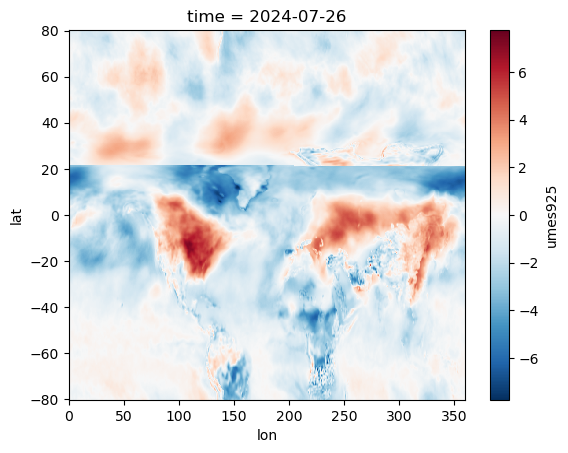

In [21]:
ds.umes925.isel(time=-1).plot()